<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Начало-теста-pipilene" data-toc-modified-id="Начало-теста-pipilene-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Начало теста pipilene</a></span></li><li><span><a href="#Векторизация" data-toc-modified-id="Векторизация-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Векторизация</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>TF-IDF</a></span></li><li><span><a href="#Балансировка-классов-для-лучшей-модели" data-toc-modified-id="Балансировка-классов-для-лучшей-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Балансировка классов для лучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
#! pip install pymystem3
#! pip install wordcloud
#! pip install pandarallel

In [2]:
import warnings
import os
import copy as cp

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from pymystem3 import Mystem

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')

from wordcloud import WordCloud

import re

from tqdm import notebook
from tqdm import tqdm

from pandarallel import pandarallel

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score 
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from typing import Tuple

from lightgbm import LGBMClassifier

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
warnings.filterwarnings('ignore')

In [4]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'datasets/toxic_comments.csv'
pth3 = 'toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
else:
    print('Something is wrong')

In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Наблюдается дисбаланс классов.

In [8]:
df['Unnamed: 0'].describe()

count    159292.000000
mean      79725.697242
std       46028.837471
min           0.000000
25%       39872.750000
50%       79721.500000
75%      119573.250000
max      159450.000000
Name: Unnamed: 0, dtype: float64

Вероятнее всего `Unnamed: 0` явлется индексом, удалим этот столбец.

In [9]:
df = df.drop('Unnamed: 0', axis=1)

In [10]:
df.duplicated().sum()

0

**Вывод** 

В нашем распоряжении массив данных размером 159 тысяч строк, доля положительных классов порядка 10%, пропуски/дубликаты отсутствуют.

## Предобработка данных

In [11]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def preprocessing(text):
    import nltk
    import re
    tokenized = nltk.word_tokenize(text.lower())
    joined = ' '.join(tokenized)
    text_only = re.sub(r'[^a-zA-Z]', ' ', joined)
    final = ' '.join(text_only.split())
    return final

In [13]:
df['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [20]:
notebook.tqdm.pandas()
df['text_final'] = df['text'].progress_apply(preprocessing)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [15]:
# df['text_final'] = df['text'].swifter.apply(preprocessing)

In [ ]:
pandarallel.initialize(progress_bar = True)
tqdm.pandas(desc="progress")

df['text_final'] = df['text'].parallel_apply(preprocessing)

In [21]:
df['text_final'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were n t vandalisms just closure on some gas after i voted at new york dolls fac and please do n t remove the template from the talk page since i m retired now'

In [22]:
RANDOM_STATE = 11363
RANDOM_SEED = RANDOM_STATE

In [23]:
X = ['text_final']
y = ['toxic']

In [24]:
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df[y])

In [25]:
print('-------Обучающая выборка-------')
print(f'Размер {train.shape}')
print(f'Баланс классов {train[y].value_counts(normalize=True)}\n')

print('-------Тестовая выборка-------')
print(f'Размер {test.shape}')
print(f'Баланс классов {test[y].value_counts(normalize=True)}')

-------Обучающая выборка-------
Размер (127433, 3)
Баланс классов toxic
0        0.898386
1        0.101614
dtype: float64

-------Тестовая выборка-------
Размер (31859, 3)
Баланс классов toxic
0        0.898396
1        0.101604
dtype: float64


Wall time: 1min 24s


(-0.5, 399.5, 199.5, -0.5)

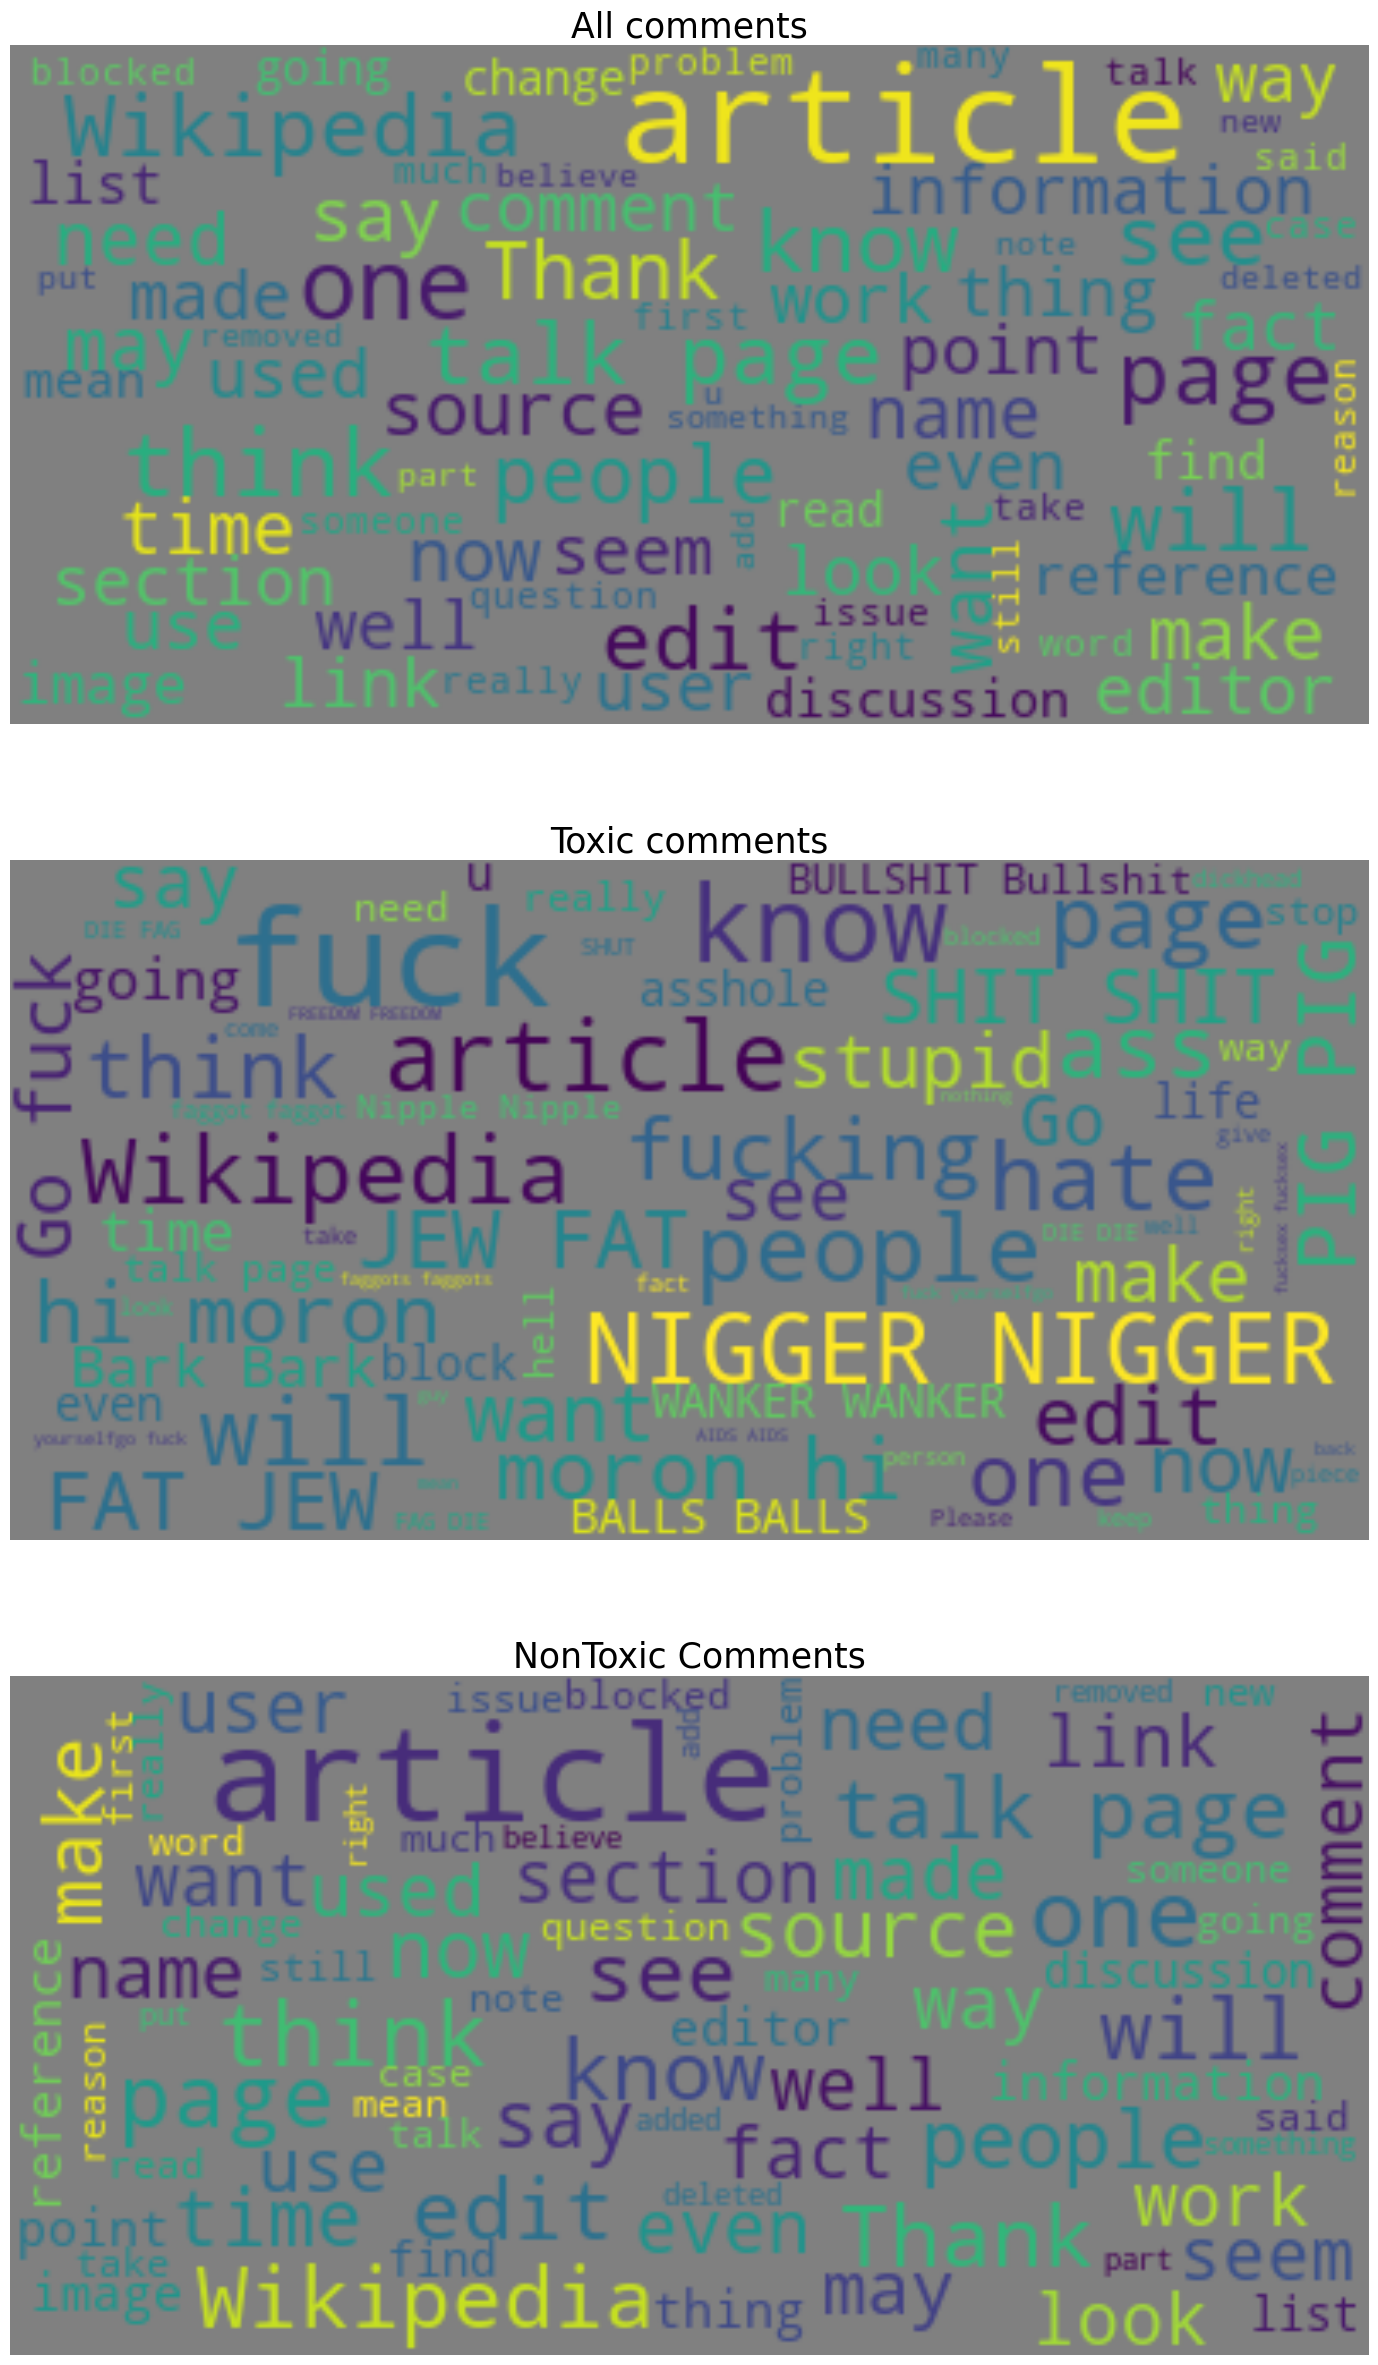

In [22]:
%%time
df_toxic = df[df['toxic']==1]
df_nottoxic = df[df['toxic']==0]

All = ' '.join(review for review in df.text)
toxic = ' '.join(review for review in df_toxic.text)
nottoxic = ' '.join(review for review in df_nottoxic.text)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
wordcloud_all = WordCloud(max_font_size=40, max_words=75, background_color='grey').generate(All)
wordcloud_toxic = WordCloud(max_font_size=40, max_words=75, background_color='grey').generate(toxic)
wordcloud_nottoxic = WordCloud(max_font_size=40, max_words=75, background_color='grey').generate(nottoxic)


ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All comments', fontsize=25)
ax[0].axis('off')
ax[1].imshow(wordcloud_toxic, interpolation='bilinear')
ax[1].set_title('Toxic comments',fontsize=25)
ax[1].axis('off')
ax[2].imshow(wordcloud_nottoxic, interpolation='bilinear')
ax[2].set_title('NonToxic Comments',fontsize=25)
ax[2].axis('off');

In [26]:
train_corpus = train[X].values
test_corpus = test[X].values

**Вывод**

Выполнена лемматизация текста, очистка от stop words, выполнен анализ типа word cloud, данные разбиты на обучающую и тестовую выборки с использованием стратификации.

## Обучение

In [27]:
kfold = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

In [28]:
def go_grid(model, grid_params, x_train, y_train):
    clf_gs = GridSearchCV(model, grid_params, cv=5, verbose=3, n_jobs=-2, scoring='f1')
    clf_gs.fit(x_train,y_train)
   
    cv_f1_score = clf_gs.best_score_
        
    name = str(model).split(sep='(')[0]
    
    return cv_f1_score, name, clf_gs.best_params_

In [29]:
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba

In [30]:
def plot_cm_rocauc(model_name, actual_classes, predicted_classes, predicted_proba, sorted_labels = ["Non Toxic", "Toxic"]):

    matrix = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="gnuplot", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix');

    plt.show()
        
    probabilities_one = predicted_proba[:, 1]
    
    sns.set(rc={'figure.figsize':(10, 6)})
    
    fpr, tpr, thresholds = roc_curve(actual_classes, probabilities_one) 
    plt.figure()

    # < построим график >
    plt.plot(fpr, tpr)

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая модели ' + model_name)

    plt.show()
    
    print(f'ROC-AUC score модели {model_name} = {roc_auc_score(actual_classes, probabilities_one):.3f}')
    
    return roc_auc_score(actual_classes, probabilities_one)

In [31]:
# Создадим функцию для построения графика ROC кривой и визуализации Confusion Matrix, а также расчёта ROC-AUC score

def r_con_mat_display(model, x, y, model_name : str):
    probabilities_valid = model.predict_proba(x)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    sns.set(rc={'figure.figsize':(10, 6)})
    
    fpr, tpr, thresholds = roc_curve(y, probabilities_one_valid) 
    plt.figure()

    # < построим график >
    plt.plot(fpr, tpr)

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая модели ' + model_name)

    plt.show()
    
    print(f'ROC-AUC score модели {model_name} = {roc_auc_score(y, probabilities_one_valid):.3f}')

    cm = confusion_matrix(y, model.predict(x))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
   
    plt.grid(False)

    plt.title('Confusion matrix модели ' + model_name)
    plt.show()
    
    return roc_auc_score(y, probabilities_one_valid)

In [32]:
results = pd.DataFrame({'Preprocessing model' : [],
                        'Learning model' : [],
                        'CV F1-score' : [],
                        'CV ROC-AUC' : [],
                        'Best params' : []
})

### Начало теста pipilene

In [33]:
pipeline_lr_cv = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=list(stop_words), dtype=np.float32)),
        ("clf", LogisticRegression(n_jobs=-2)),
    ]
)

In [34]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (2, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "clf__C": np.logspace(-6, 6, 20),
}

In [40]:
random_search = RandomizedSearchCV(
    estimator=pipeline_lr_cv,
    param_distributions=parameter_grid,
    n_iter=2,
    random_state=RANDOM_STATE,
    verbose=3,
    scoring='f1',
    return_train_score=True
)

In [41]:
from pprint import pprint
print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__C': array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (2, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2))}


In [42]:
%%time
random_search.fit(train_corpus.ravel(), train[y])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END clf__C=2976.3514416313133, vect__max_df=0.8, vect__min_df=10, vect__ngram_range=(1, 1); total time=  38.2s
[CV 2/5] END clf__C=2976.3514416313133, vect__max_df=0.8, vect__min_df=10, vect__ngram_range=(1, 1); total time=  42.1s
[CV 3/5] END clf__C=2976.3514416313133, vect__max_df=0.8, vect__min_df=10, vect__ngram_range=(1, 1); total time=  32.9s
[CV 4/5] END clf__C=2976.3514416313133, vect__max_df=0.8, vect__min_df=10, vect__ngram_range=(1, 1); total time=  30.9s
[CV 5/5] END clf__C=2976.3514416313133, vect__max_df=0.8, vect__min_df=10, vect__ngram_range=(1, 1); total time=  33.1s
[CV 1/5] END clf__C=2.06913808111479, vect__max_df=0.2, vect__min_df=3, vect__ngram_range=(1, 1); total time=  33.3s
[CV 2/5] END clf__C=2.06913808111479, vect__max_df=0.2, vect__min_df=3, vect__ngram_range=(1, 1); total time=  36.1s
[CV 3/5] END clf__C=2.06913808111479, vect__max_df=0.2, vect__min_df=3, vect__ngram_range=(1, 1); total ti

RandomizedSearchCV(estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(dtype=<class 'numpy.float32'>,
                                                              stop_words=['only',
                                                                          'is',
                                                                          'with',
                                                                          'too',
                                                                          'o',
                                                                          'as',
                                                                          'because',
                                                                          'until',
                                                                          'few',
                                                                          'it',
                                        

In [43]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__C: 2976.3514416313133
vect__max_df: 1.0
vect__min_df: 2
vect__ngram_range: (1, 2)


In [44]:
%%time
test_accuracy = random_search.score(test_corpus.ravel(), test[y])
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.767
Accuracy on test set: 0.774
Wall time: 3.07 s


In [45]:
pipeline_lr_idf = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words=list(stop_words), dtype=np.float32)),
        ("clf", LogisticRegression(n_jobs=-2)),
    ]
)

In [46]:
pipeline_lr_idf

Pipeline(steps=[('vect',
                 TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                 stop_words=['over', 'you', 's', 'i', 'shan',
                                             'at', 'very', 'be', 'while',
                                             'where', "couldn't", "haven't",
                                             'not', "won't", 'been', 'was',
                                             'ourselves', 'wouldn', 'after',
                                             'were', 'here', 'further', 'any',
                                             've', 'they', 'to', 'couldn',
                                             'into', 'only', 'his', ...])),
                ('clf', LogisticRegression(n_jobs=-2))])

In [47]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (2, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "clf__C": np.logspace(-6, 6, 20),
}

In [48]:
random_search = RandomizedSearchCV(
    estimator=pipeline_lr_idf,
    param_distributions=parameter_grid,
    n_iter=50,
    random_state=RANDOM_STATE,
    n_jobs=-2,
    verbose=1,
    scoring='f1'
)

In [49]:
print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__C': array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06]),
 'vect__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vect__min_df': (2, 3, 5, 10),
 'vect__ngram_range': ((1, 1), (1, 2))}


In [50]:
%%time
random_search.fit(train_corpus.ravel(), train[y])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Wall time: 15min 45s


RandomizedSearchCV(estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                                              stop_words=['over',
                                                                          'you',
                                                                          's',
                                                                          'i',
                                                                          'shan',
                                                                          'at',
                                                                          'very',
                                                                          'be',
                                                                          'while',
                                                                          'where',
                                          

In [51]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__C: 8.858667904100814
vect__max_df: 0.4
vect__min_df: 3
vect__ngram_range: (1, 1)


In [52]:
%%time
test_accuracy = random_search.score(test_corpus.ravel(), test[y])
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.772
Accuracy on test set: 0.770
Wall time: 2.06 s


### Векторизация

In [53]:
vectorizer = CountVectorizer(stop_words=list(stop_words), dtype=np.float32)

In [54]:
%%time
train_vectorized = vectorizer.fit_transform(train_corpus.ravel())
test_vectorized = vectorizer.transform(test_corpus.ravel())

Wall time: 10.2 s


In [55]:
%%time
model = LogisticRegression(n_jobs=-2)
grid_params = {'C':np.logspace(-6, 6, 20)}
cv_f1_score, name, best_params = go_grid(model,
                                         grid_params,
                                         train_vectorized,
                                         train[y])

model = LogisticRegression(**best_params, n_jobs=-2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 2min 39s


In [56]:
%%time
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, train_vectorized, train[y].values)

Wall time: 27.7 s


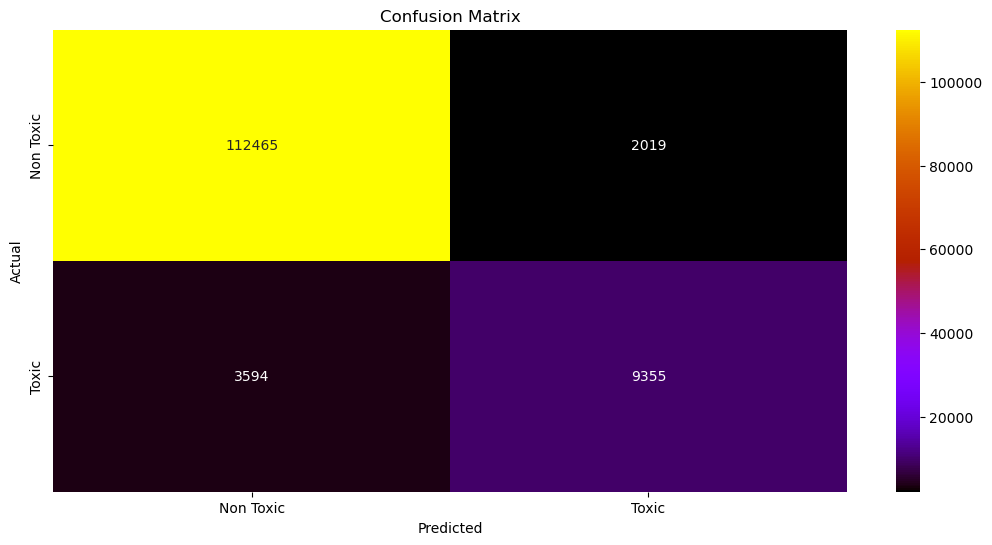

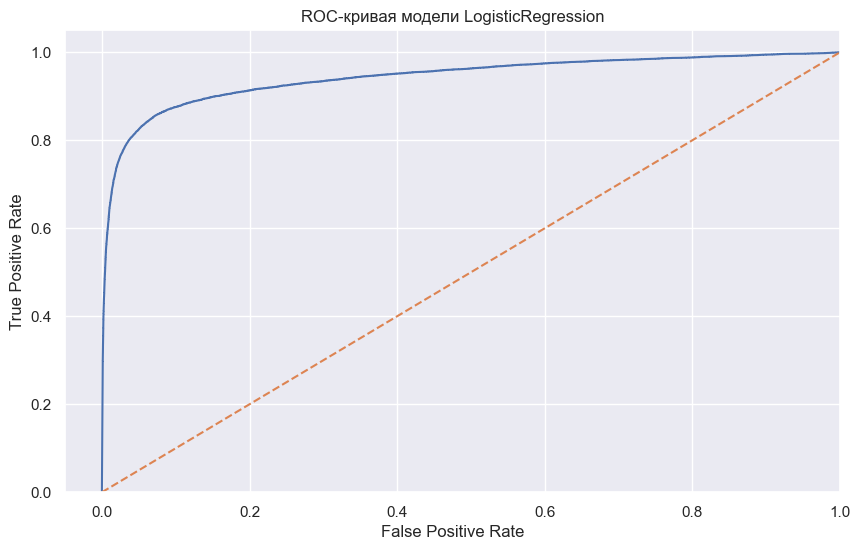

ROC-AUC score модели LogisticRegression = 0.943
Wall time: 659 ms


In [57]:
%%time
cv_roc_auc = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)

In [58]:
results = results.append({
            'Preprocessing model' : 'CountVectorizer',
            'Learning model' : name, 
            'CV F1-score' : round(cv_f1_score, 3),
            'CV ROC-AUC' : round(cv_roc_auc, 3),
            'Best params' : best_params},
            ignore_index=True)

In [59]:
results.iloc[:,:4]

,Preprocessing model,Learning model,CV F1-score,CV ROC-AUC
0,CountVectorizer,LogisticRegression,0.765,0.943


In [60]:
%%time
model = DecisionTreeClassifier()

grid_params = {'criterion':['gini','entropy'],
               'max_depth':[50, 150]}

cv_f1_score, name, best_params = go_grid(model,
                                         grid_params,
                                         train_vectorized,
                                         train[y])

model = DecisionTreeClassifier(**best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Wall time: 6min 14s


In [61]:
%%time
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, train_vectorized, train[y].values)

Wall time: 6min 51s


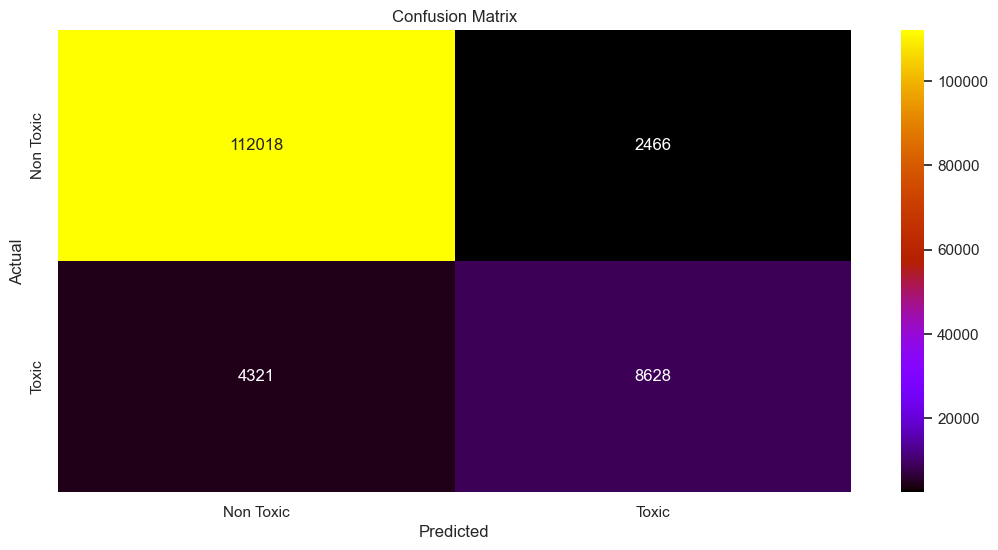

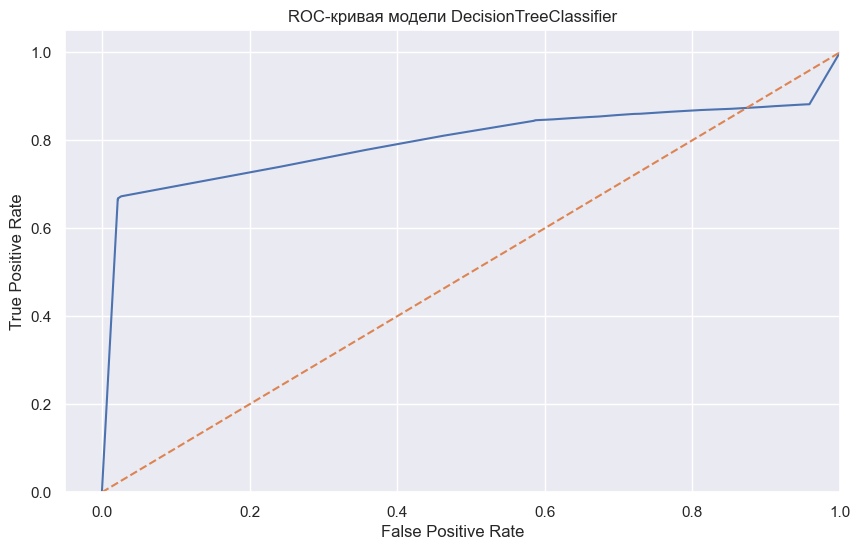

ROC-AUC score модели DecisionTreeClassifier = 0.797
Wall time: 490 ms


In [62]:
%%time
cv_roc_auc = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)

In [63]:
results = results.append({
            'Preprocessing model' : 'CountVectorizer',
            'Learning model' : name, 
            'CV F1-score' : round(cv_f1_score, 3),
            'CV ROC-AUC' : round(cv_roc_auc, 3),
            'Best params' : best_params},
            ignore_index=True)

In [64]:
results.iloc[:,:4]

,Preprocessing model,Learning model,CV F1-score,CV ROC-AUC
0,CountVectorizer,LogisticRegression,0.765,0.943
1,CountVectorizer,DecisionTreeClassifier,0.722,0.797


In [65]:
%%time
model = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-2)

grid_params  = {'learning_rate': [0.1, 0.01],
                'n_estimators': [50, 100, 150],
                'max_depth': [10, 50, 150]}

cv_f1_score, name, best_params = go_grid(model,
                                         grid_params,
                                         train_vectorized,
                                         train[y])

model = LGBMClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 13min 20s


In [66]:
%%time
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, train_vectorized, train[y].values)

Wall time: 1min 6s


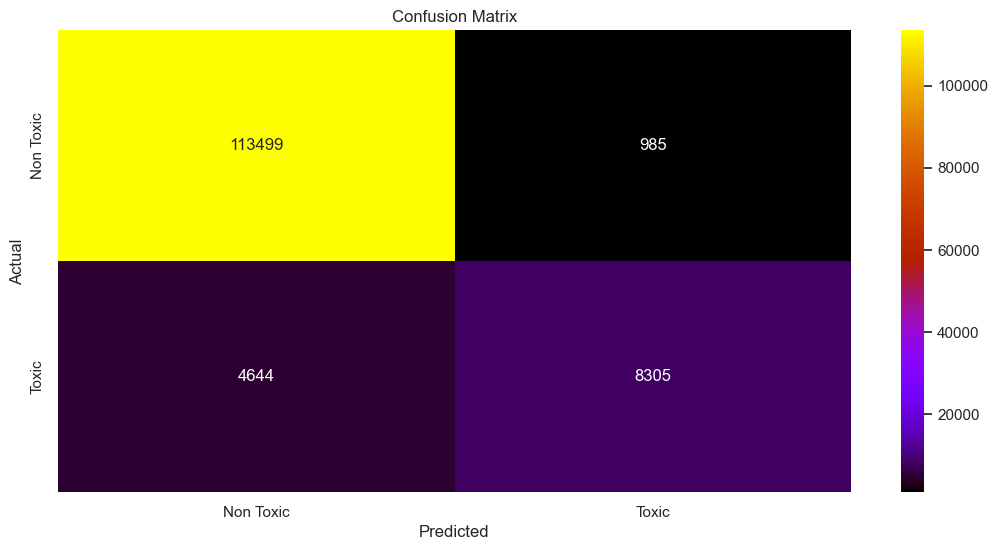

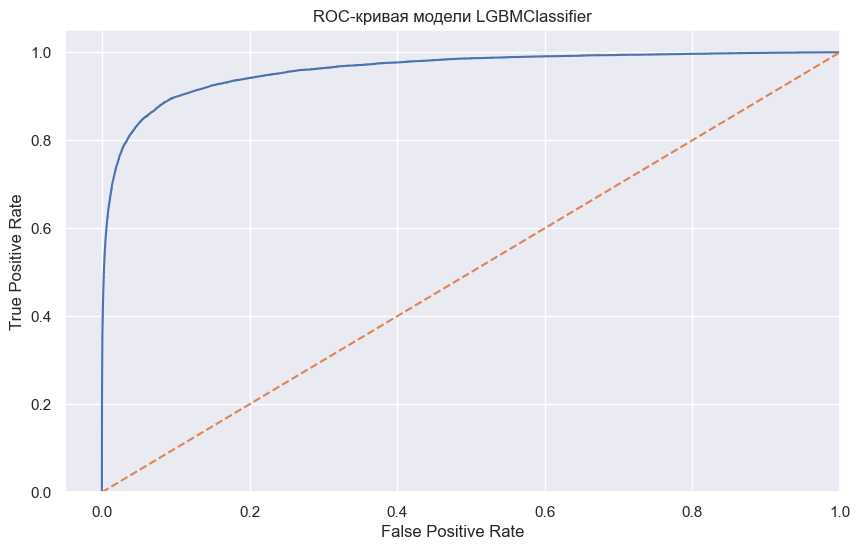

ROC-AUC score модели LGBMClassifier = 0.960
Wall time: 1.07 s


In [67]:
%%time
cv_roc_auc = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)

In [68]:
results = results.append({
            'Preprocessing model' : 'CountVectorizer',
            'Learning model' : name, 
            'CV F1-score' : round(cv_f1_score, 3),
            'CV ROC-AUC' : round(cv_roc_auc, 3),
            'Best params' : best_params},
            ignore_index=True)

In [69]:
results.iloc[:,:4]

,Preprocessing model,Learning model,CV F1-score,CV ROC-AUC
0,CountVectorizer,LogisticRegression,0.765,0.943
1,CountVectorizer,DecisionTreeClassifier,0.722,0.797
2,CountVectorizer,LGBMClassifier,0.745,0.960


### TF-IDF

In [70]:
tf_idf = TfidfVectorizer(stop_words=list(stop_words), dtype=np.float32)

In [71]:
%%time
train_vectorized_idf = tf_idf.fit_transform(train_corpus.ravel())
test_vectorized_idf = tf_idf.transform(test_corpus.ravel())

Wall time: 10.5 s


In [72]:
%%time
model = LogisticRegression(n_jobs=-1)

grid_params = {'C':np.logspace(-6, 6, 20)}

cv_f1_score, name, best_params = go_grid(model,
                                         grid_params,
                                         train_vectorized_idf,
                                         train[y])

model = LogisticRegression(**best_params, n_jobs=-1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 2min 27s


In [73]:
%%time
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, train_vectorized_idf, train[y].values)

Wall time: 29.3 s


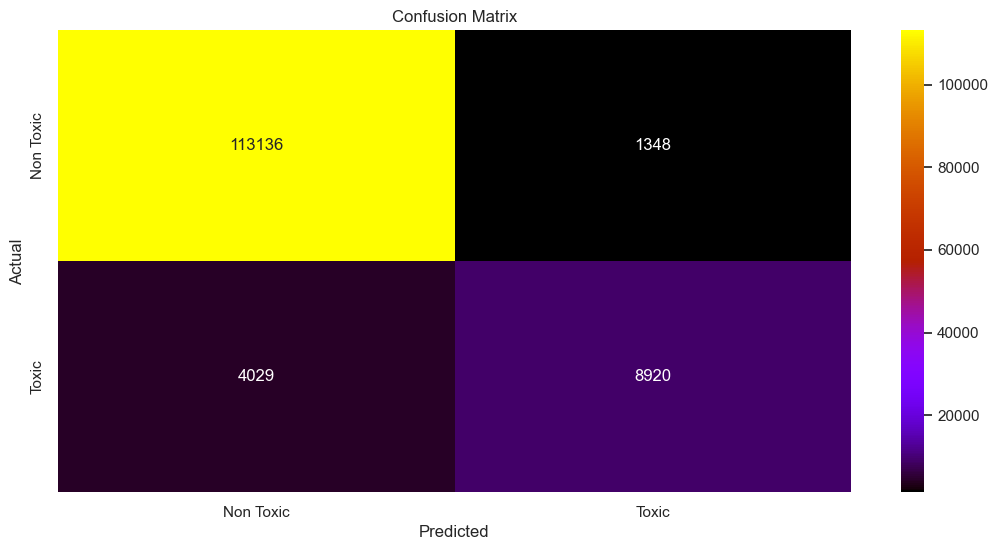

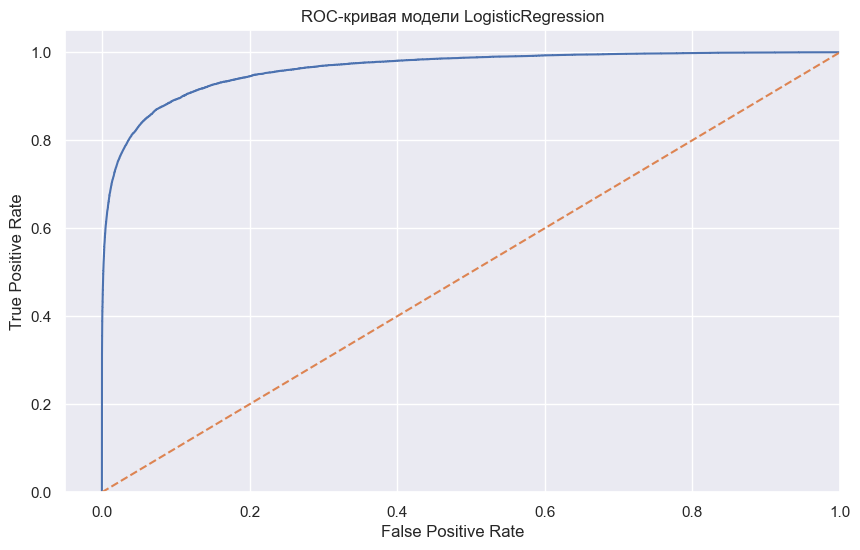

ROC-AUC score модели LogisticRegression = 0.962
Wall time: 539 ms


In [74]:
%%time
cv_roc_auc = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)

In [75]:
results = results.append({
            'Preprocessing model' : 'TfidfVectorizer',
            'Learning model' : name, 
            'CV F1-score' : round(cv_f1_score, 3),
            'CV ROC-AUC' : round(cv_roc_auc, 3),
            'Best params' : best_params},
            ignore_index=True)

In [76]:
results.iloc[:,:4]

,Preprocessing model,Learning model,CV F1-score,CV ROC-AUC
0,CountVectorizer,LogisticRegression,0.765,0.943
1,CountVectorizer,DecisionTreeClassifier,0.722,0.797
2,CountVectorizer,LGBMClassifier,0.745,0.960
3,TfidfVectorizer,LogisticRegression,0.766,0.962


In [77]:
%%time
model = DecisionTreeClassifier()

grid_params = {'criterion':['gini','entropy'],
               'max_depth':[50, 150]}

cv_f1_score, name, best_params = go_grid(model,
                                         grid_params,
                                         train_vectorized_idf,
                                         train[y])

model = DecisionTreeClassifier(**best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Wall time: 9min 21s


In [78]:
%%time
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, train_vectorized_idf, train[y].values)

Wall time: 7min 20s


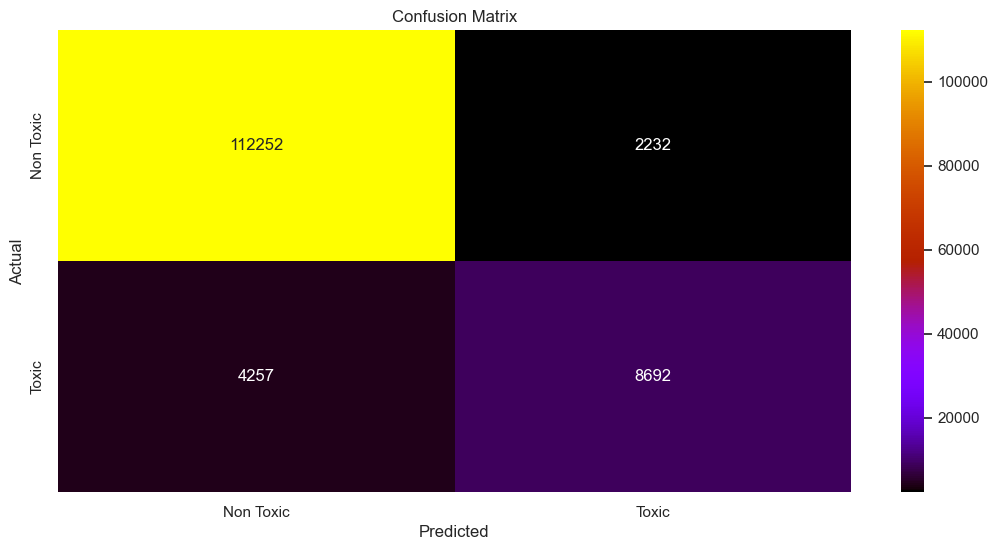

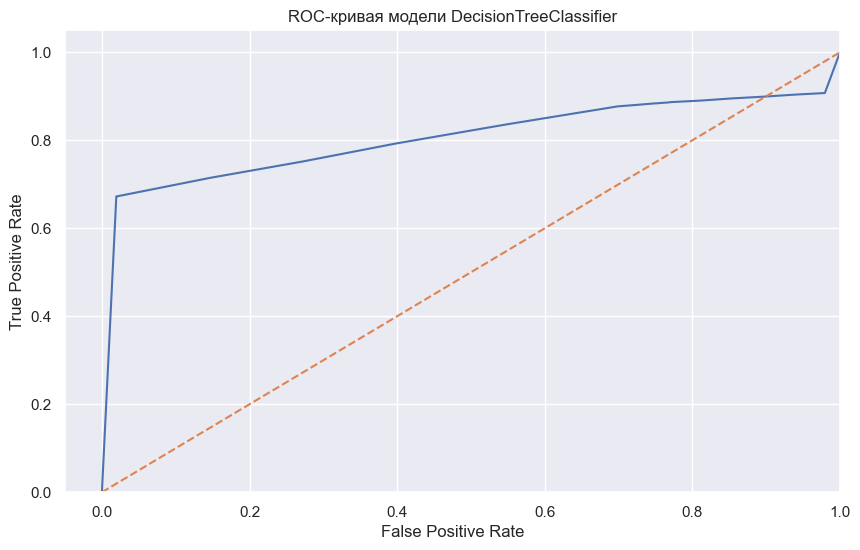

ROC-AUC score модели DecisionTreeClassifier = 0.805
Wall time: 489 ms


In [79]:
%%time
cv_roc_auc = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)

In [80]:
results = results.append({
            'Preprocessing model' : 'TfidfVectorizer',
            'Learning model' : name, 
            'CV F1-score' : round(cv_f1_score, 3),
            'CV ROC-AUC' : round(cv_roc_auc, 3),
            'Best params' : best_params},
            ignore_index=True)

In [81]:
results.iloc[:,:4]

,Preprocessing model,Learning model,CV F1-score,CV ROC-AUC
0,CountVectorizer,LogisticRegression,0.765,0.943
1,CountVectorizer,DecisionTreeClassifier,0.722,0.797
2,CountVectorizer,LGBMClassifier,0.745,0.960
3,TfidfVectorizer,LogisticRegression,0.766,0.962
4,TfidfVectorizer,DecisionTreeClassifier,0.726,0.805


In [82]:
%%time
model = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-2)

grid_params  = {'learning_rate': [0.1, 0.01],
                'n_estimators': [50, 100, 150],
                'max_depth': [10, 50, 150]}

cv_f1_score, name, best_params = go_grid(model,
                                         grid_params,
                                         train_vectorized_idf,
                                         train[y])

model = LGBMClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 19min 16s


In [83]:
%%time
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, train_vectorized_idf, train[y].values)

Wall time: 2min 27s


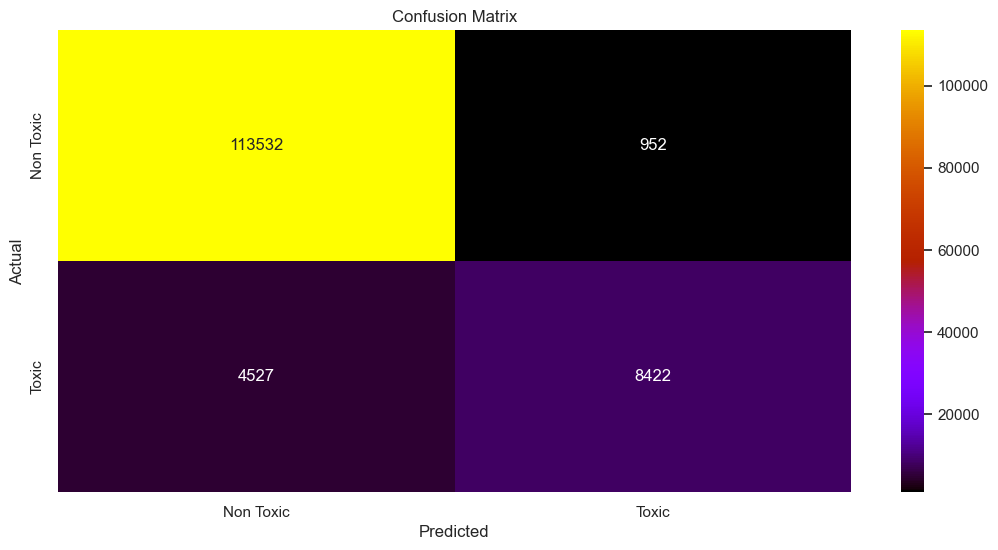

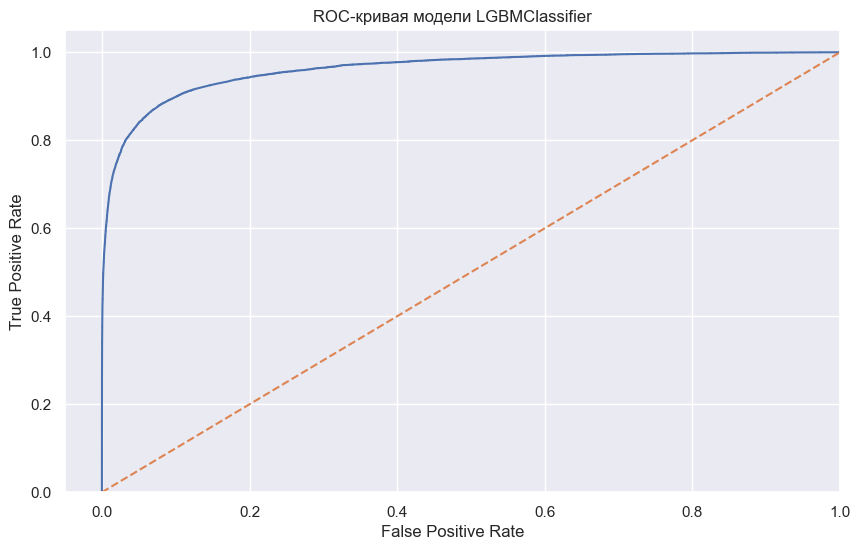

ROC-AUC score модели LGBMClassifier = 0.962
Wall time: 533 ms


In [84]:
%%time
cv_roc_auc = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)

In [85]:
results = results.append({
            'Preprocessing model' : 'TfidfVectorizer',
            'Learning model' : name, 
            'CV F1-score' : round(cv_f1_score, 3),
            'CV ROC-AUC' : round(cv_roc_auc, 3),
            'Best params' : best_params},
            ignore_index=True)

In [126]:
results.iloc[:,:4]

,Preprocessing model,Learning model,CV F1-score,CV ROC-AUC
0,CountVectorizer,LogisticRegression,0.765,0.943
1,CountVectorizer,DecisionTreeClassifier,0.722,0.797
2,CountVectorizer,LGBMClassifier,0.745,0.960
3,TfidfVectorizer,LogisticRegression,0.766,0.962
4,TfidfVectorizer,DecisionTreeClassifier,0.726,0.805
5,TfidfVectorizer,LGBMClassifier,0.756,0.962
6,TfidfVectorizer,LogisticRegression balanced,0.768,0.969


### Балансировка классов для лучшей модели

In [97]:
%%time
model = LogisticRegression(n_jobs=-1, class_weight='balanced')

grid_params = {'C':np.logspace(-6, 6, 20)}

cv_f1_score, name, best_params = go_grid(model,
                                         grid_params,
                                         train_vectorized_idf,
                                         train[y])

model = LogisticRegression(**best_params, n_jobs=-1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 2min 26s


In [98]:
%%time
actual_classes, predicted_classes, predicted_proba = cross_val_predict(model, kfold, train_vectorized_idf, train[y].values)

Wall time: 29.9 s


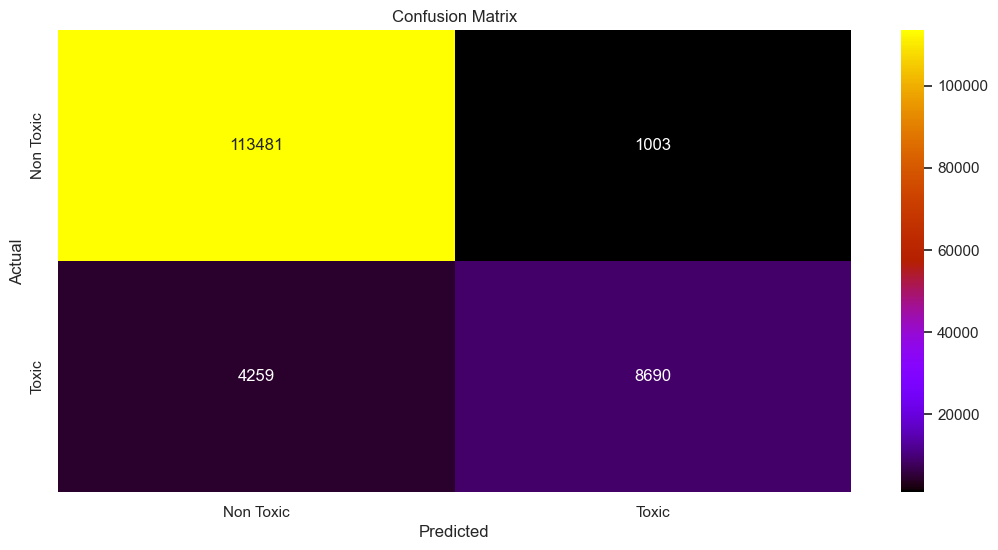

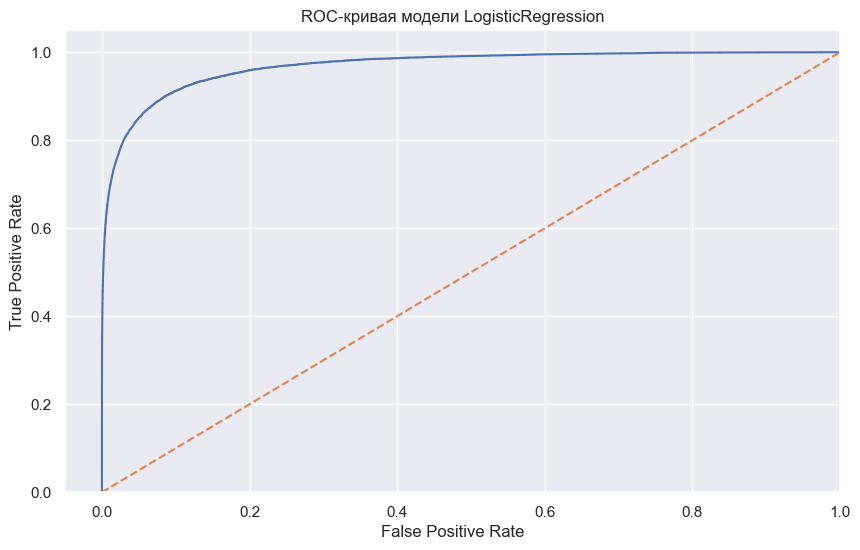

ROC-AUC score модели LogisticRegression = 0.969
Wall time: 548 ms


In [99]:
%%time
cv_roc_auc = plot_cm_rocauc(name, actual_classes, predicted_classes, predicted_proba)

In [100]:
results = results.append({
            'Preprocessing model' : 'TfidfVectorizer',
            'Learning model' : name + ' balanced', 
            'CV F1-score' : round(cv_f1_score, 3),
            'CV ROC-AUC' : round(cv_roc_auc, 3),
            'Best params' : best_params},
            ignore_index=True)

In [116]:
results.sort_values('CV F1-score', ascending=False).iloc[:,:4]

,Preprocessing model,Learning model,CV F1-score,CV ROC-AUC
6,TfidfVectorizer,LogisticRegression balanced,0.768,0.969
3,TfidfVectorizer,LogisticRegression,0.766,0.962
0,CountVectorizer,LogisticRegression,0.765,0.943
5,TfidfVectorizer,LGBMClassifier,0.756,0.962
2,CountVectorizer,LGBMClassifier,0.745,0.960
4,TfidfVectorizer,DecisionTreeClassifier,0.726,0.805
1,CountVectorizer,DecisionTreeClassifier,0.722,0.797


**Вывод**

Наилучший показатель F1 меры продемонстрировала модель логистической регресии с балансировкой классов и использованием `TfidfVectorizer` = 0.768.

## Тестирование

In [105]:
best_params = results.sort_values('CV F1-score', ascending=False).iloc[0,4]

In [106]:
model = LogisticRegression(n_jobs=-2, **best_params, class_weight='balanced')
model.fit(train_vectorized_idf, train[y]);

In [109]:
print(f'{model}\nобеспечивает показатель F1_score на тестовой выборке {f1_score(test[y], model.predict(test_vectorized_idf)):.3f}')

LogisticRegression(C=8.858667904100814, class_weight='balanced', n_jobs=-2)
 обеспечивает показатель F1_score на тестовой выборке 0.773


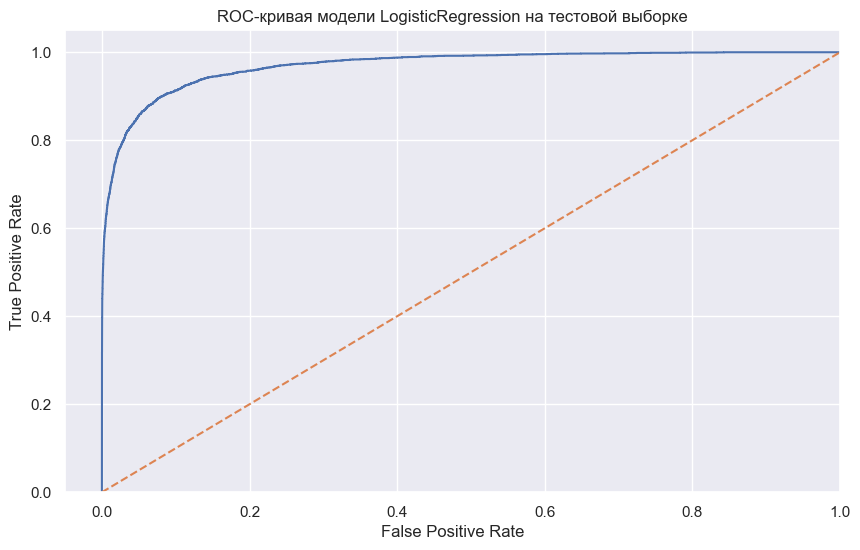

ROC-AUC score модели LogisticRegression на тестовой выборке = 0.970


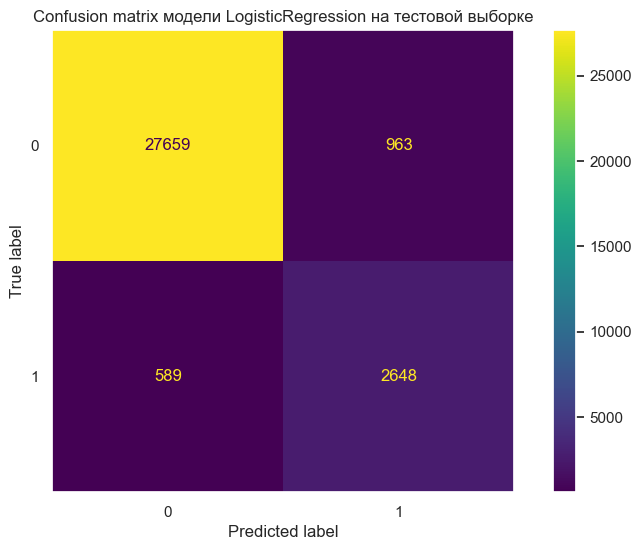

0.9695649774967816

In [108]:
r_con_mat_display(model, test_vectorized_idf, test[y], 'LogisticRegression на тестовой выборке')

Модель LogisticRegression демонстрирует F1-меру на тестовой выборке 0.773, ROC-AUC = 0.970.

## Общий вывод

- в нашем распоряжении массив данных размером 159 тысяч строк, доля положительных классов порядка 10%, пропуски/дубликаты отсутствуют;
- на этапе предобработки данных была выполнена лемматизация текста, очистка от stop words, выполнен анализ типа word cloud, данные разбиты на обучающую и тестовую выборки с использованием стратификации;
- на этапе обучения мы использовали два способа векторизации (CountVectorizer TfidfVectorizer), и три модели (LogisticRegression, DecisionTree и LGBM);
- наилучший показатель F1-меры = 0.768 в ходе CV продемонстрировала модель логистической регресии с использованием TfidfVectorizer и балансировкой классов;
- на тестовой выборке F1-мера = 0.773.